In [1]:
%load_ext autoreload
%autoreload 2
import sys
from pathlib import Path
path = str(Path.cwd().parent)
print(path)
sys.path.insert(1, path)

import numpy as np
import pandas as pd
import skforecast

print(skforecast.__version__)

c:\Users\jaesc2\GitHub\skforecast
0.18.0


In [2]:
# Libraries
# ==============================================================================
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from skforecast.datasets import fetch_dataset
from skforecast.preprocessing import RollingFeatures
from skforecast.recursive import ForecasterRecursive
from skforecast.model_selection import TimeSeriesFold
from skforecast.model_selection import backtesting_forecaster
from skforecast.plot import plot_prediction_intervals, set_dark_theme, backtesting_gif_creator

In [3]:
# Download data
# ==============================================================================
data = fetch_dataset(
    name="h2o", raw=True, kwargs_read_csv={"names": ["y", "datetime"], "header": 0}
)

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y-%m-%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data[['y']]
data = data.sort_index()
data.head(3)

h2o
---
Monthly expenditure ($AUD) on corticosteroid drugs that the Australian health
system had between 1991 and 2008.
Hyndman R (2023). fpp3: Data for Forecasting: Principles and Practice(3rd
Edition). http://pkg.robjhyndman.com/fpp3package/,https://github.com/robjhyndman
/fpp3package, http://OTexts.com/fpp3.
Shape of the dataset: (204, 2)


,y
datetime,
1991-07-01,0.429795
1991-08-01,0.400906
1991-09-01,0.432159


Train dates      : 1991-07-01 00:00:00 --- 2002-01-01 00:00:00  (n=127)
Validation dates : 2002-02-01 00:00:00 --- 2008-06-01 00:00:00  (n=77)


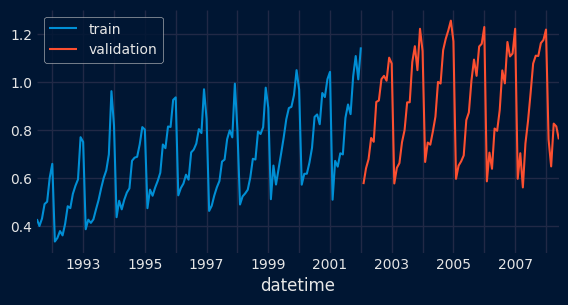

In [4]:
# Train-validation dates
# ==============================================================================
end_train = '2002-01-01 23:59:00'

print(
    f"Train dates      : {data.index.min()} --- {data.loc[:end_train].index.max()}"
    f"  (n={len(data.loc[:end_train])})"
)
print(
    f"Validation dates : {data.loc[end_train:].index.min()} --- {data.index.max()}"
    f"  (n={len(data.loc[end_train:])})"
)

# Plot
# ==============================================================================
set_dark_theme()
fig, ax = plt.subplots(figsize=(6, 3))
data.loc[:end_train, 'y'].plot(ax=ax, label='train')
data.loc[end_train:, 'y'].plot(ax=ax, label='validation')
ax.legend()
plt.show();

## Backtesting without refit

In [5]:
window_size        = 12
steps              = 10
initial_train_size = 96
fps = 2
dpi = 120

In [6]:
cv = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = initial_train_size,
         window_size           = window_size,
         refit                 = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

In [7]:
plt.rcdefaults()   # Restaura todos los rcParams al estado por defecto
plt.style.use('default')  # Aplica el estilo 'default'
backtesting_gif_creator(
    data             = data['y'],
    cv               = cv,
    series_to_plot   = None,
    plot_last_window = False,
    filename         = "img/time-series-backtesting-forecasting-no-refit.gif",
    figsize          = (9, 4),
    plt_style        = 'ggplot',
    title_template   = "Backtesting no refit — Fold {fold_num}",
    fps              = fps,
    dpi              = dpi
)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast/tools/img/time-series-backtesting-forecasting-no-refit.gif')

## Backtesting with refit and increasing training size

In [8]:
cv = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = initial_train_size,
         window_size           = window_size,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

In [9]:
plt.rcdefaults()   # Restaura todos los rcParams al estado por defecto
plt.style.use('default')  # Aplica el estilo 'default'
backtesting_gif_creator(
    data             = data['y'],
    cv               = cv,
    series_to_plot   = None,
    plot_last_window = False,
    filename         = "img/time-series-backtesting-forecasting-with-refit.gif",
    figsize          = (9, 4),
    plt_style        = 'ggplot',
    title_template   = "Backtesting with refit — Fold {fold_num} (refit: {refit})",
    fps              = fps,
    dpi              = dpi
)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast/tools/img/time-series-backtesting-forecasting-with-refit.gif')

## Backtesting with refit and fixed training size

In [10]:
cv = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = initial_train_size,
         window_size           = window_size,
         refit                 = True,
         fixed_train_size      = True,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

In [11]:
plt.rcdefaults()   # Restaura todos los rcParams al estado por defecto
plt.style.use('default')  # Aplica el estilo 'default'
backtesting_gif_creator(
    data             = data['y'],
    cv               = cv,
    series_to_plot   = None,
    plot_last_window = False,
    filename         = "img/time-series-backtesting-forecasting-refit-fixed-train-size.gif",
    figsize          = (9, 4),
    plt_style        = 'ggplot',
    title_template   = "Backtesting with refit and fixed train size — Fold {fold_num} (refit: {refit})",
    fps              = fps,
    dpi              = dpi
)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast/tools/img/time-series-backtesting-forecasting-refit-fixed-train-size.gif')

## Backtesting with intermittent refit

In [12]:
cv = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = initial_train_size,
         window_size           = window_size,
         refit                 = 4,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

In [13]:
plt.rcdefaults()   # Restaura todos los rcParams al estado por defecto
plt.style.use('default')  # Aplica el estilo 'default'
backtesting_gif_creator(
    data             = data['y'],
    cv               = cv,
    series_to_plot   = None,
    plot_last_window = False,
    filename         = "img/time-series-backtesting-forecasting-intermittent-refit.gif",
    figsize          = (9, 4),
    plt_style        = 'ggplot',
    title_template   = "Backtesting with intermittent refit — Fold {fold_num} (refit: {refit})",
    fps              = fps,
    dpi              = dpi
)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast/tools/img/time-series-backtesting-forecasting-intermittent-refit.gif')

## Backtesting including gap

In [14]:
cv = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = initial_train_size,
         window_size           = window_size,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 5,
         allow_incomplete_fold = True,
         verbose               = False
     )

In [15]:
plt.rcdefaults()   # Restaura todos los rcParams al estado por defecto
plt.style.use('default')  # Aplica el estilo 'default'
backtesting_gif_creator(
    data             = data['y'],
    cv               = cv,
    series_to_plot   = None,
    plot_last_window = False,
    filename         = "img/time-series-backtesting-forecasting-with-gap.gif",
    figsize          = (9, 4),
    plt_style        = 'ggplot',
    title_template   = "Backtesting with refit and gap — Fold {fold_num} (refit: {refit})",
    fps              = fps,
    dpi              = dpi
)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast/tools/img/time-series-backtesting-forecasting-with-gap.gif')

## Backtesting with fold stride

In [16]:
cv = TimeSeriesFold(
         steps                 = steps,
         initial_train_size    = initial_train_size,
         fold_stride           = int(steps / 2),
         window_size           = window_size,
         refit                 = True,
         fixed_train_size      = False,
         gap                   = 0,
         allow_incomplete_fold = True,
         verbose               = False
     )

In [17]:
plt.rcdefaults()   # Restaura todos los rcParams al estado por defecto
plt.style.use('default')  # Aplica el estilo 'default'
backtesting_gif_creator(
    data             = data['y'],
    cv               = cv,
    series_to_plot   = None,
    plot_last_window = False,
    filename         = "img/time-series-backtesting-forecasting-fold-stride.gif",
    figsize          = (9, 4),
    plt_style        = 'ggplot',
    title_template   = "Backtesting with fold stride — Fold {fold_num} (refit: {refit})",
    fps              = fps,
    dpi              = dpi
)

WindowsPath('c:/Users/jaesc2/GitHub/skforecast/tools/img/time-series-backtesting-forecasting-fold-stride.gif')